<a href="https://colab.research.google.com/github/ozturkergin/ozturkergin/blob/main/TEFAS_PowerBI_Import_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install bs4 --quiet
!pip3 install urllib3 --quiet
!pip3 install marshmallow --quiet
!pip3 install pandas_ta --quiet
!pip3 install numpy --quiet
!pip3 install matplotlib --quiet
!pip3 install scikit-learn --quiet
!pip3 install tensorflow --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import requests
import pandas as pd
import math
import concurrent.futures
import time

from datetime import datetime, timedelta, date
from typing import Dict, List, Optional, Union
from marshmallow import Schema, fields, EXCLUDE, pre_load, post_load
from bs4 import BeautifulSoup

# Special thanks to https://github.com/burakyilmaz321

class InfoSchema(Schema):
    code = fields.String(data_key="FONKODU", allow_none=True)
    fonunvantip = fields.String(data_key="FONUNVANTIP", allow_none=True)
    date = fields.Date(data_key="TARIH", allow_none=True)
    price = fields.Float(data_key="FIYAT", allow_none=True)
    title = fields.String(data_key="FONUNVAN", allow_none=True)
    market_cap = fields.Float(data_key="PORTFOYBUYUKLUK", allow_none=True)
    number_of_shares = fields.Float(data_key="TEDPAYSAYISI", allow_none=True)
    number_of_investors = fields.Float(data_key="KISISAYISI", allow_none=True)

    @pre_load
    def pre_load_hook(self, input_data, **kwargs):
        seconds_timestamp = int(input_data["TARIH"]) / 1000
        input_data["TARIH"] = date.fromtimestamp(seconds_timestamp).isoformat()
        return input_data

    @post_load
    def post_load_hool(self, output_data, **kwargs):
        output_data = {f: output_data.setdefault(f) for f in self.fields}
        return output_data

    class Meta:
        unknown = EXCLUDE

class tefas_get:
    root_url = "https://www.tefas.gov.tr"
    info_endpoint = "/api/DB/BindHistoryInfo"
    concurrently = False
    use_Proxy = False
    fon_type = "YAT"
    proxies = None

    @staticmethod
    def get_combobox_items(url, select_id):
        response = requests.get(url)
        if response.status_code != 200:
            raise Exception(f"Failed to fetch the URL: {response.status_code}")

        soup = BeautifulSoup(response.content, 'html.parser')
        select_element = soup.find('select', id=select_id)

        if not select_element:
            raise Exception(f"Select element with id '{select_id}' not found")

        options = select_element.find_all('option')
        options = list(filter(None, options))

        items = []
        for option in options:
            value = option.get('value')
            items.append(value)

        items.remove('')

        return items

    def fetch_info(self, fonunvantip, start_date_initial, end_date_initial):
        counter = 1
        start_date = start_date_initial
        end_date = end_date_initial
        range_date = end_date_initial - start_date_initial
        range_interval = 90
        info_schema = InfoSchema(many=True)
        info_result = pd.DataFrame()

        if range_date.days > range_interval :
            counter = range_date.days / range_interval
            counter = math.ceil(counter)
            end_date = start_date + timedelta(days=range_interval)

        while counter > 0:
            counter -= 1

            data = {
                    "fontip": self.fon_type,
                    "bastarih": self._parse_date(start_date),
                    "bittarih": self._parse_date(end_date),
                    "fonunvantip": fonunvantip,
                    "fonkod": "",
                  }

            info = self._do_post(data)
            info = info_schema.load(info)
            info = pd.DataFrame(info, columns=info_schema.fields.keys())
            info['fonunvantip'] = fonunvantip
            if not info.empty :
                info_result = pd.concat([info_result, info])
                info_result = info_result.reset_index(drop=True)
                info = info.reset_index(drop=True)

            if counter > 0 :
                start_date = end_date + timedelta(days=1)
                end_date = end_date + timedelta(days=range_interval)
                if end_date > end_date_initial :
                    end_date = end_date_initial

        return info_result

    def fetch_info_serial(self, fonunvantips, start_date_initial, end_date_initial):
        merged = pd.DataFrame()

        for fonunvantip in fonunvantips:
            info = self.fetch_info(fonunvantip, start_date_initial, end_date_initial)
            if not info.empty :
                merged = pd.concat([merged, info])
                print(f"{fonunvantip} - {len(info)} records added total records: {len(merged)} " )

        return merged

    def fetch_info_concurrently(self, fonunvantips, start_date_initial, end_date_initial):
        with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
            merged = pd.DataFrame()
            self.concurrently = True
            futures = {executor.submit(self.fetch_info, fonunvantip, start_date_initial, end_date_initial): fonunvantip for fonunvantip in fonunvantips}

            for future in concurrent.futures.as_completed(futures):
                info = future.result()
                merged = pd.concat([merged, info])
                print(f"{future} - {len(info)} records added total records: {len(merged)} " )

            return merged

    def fetch(
        self,
        start: Union[str, datetime],
        end: Optional[Union[str, datetime]] = None,
        columns: Optional[List[str]] = None,
        unvantip: bool = False,
    ) -> pd.DataFrame:

        start_date_initial = datetime.strptime(start, "%Y-%m-%d")
        end_date_initial = datetime.strptime(end or start, "%Y-%m-%d")

        merged = pd.DataFrame()
        fonunvantips = [""]
        if unvantip :
            fonunvantips = self.get_combobox_items(url="https://www.tefas.gov.tr/TarihselVeriler.aspx", select_id="DropDownListFundTypeExplanationYAT")

        self.proxies = None

        if self.concurrently :
            merged = self.fetch_info_concurrently(fonunvantips, start_date_initial, end_date_initial)
        else :
            merged = self.fetch_info_serial(fonunvantips, start_date_initial, end_date_initial)

        merged = merged[columns] if columns and not merged.empty else merged

        return merged

    # def get_free_proxy(self):
    #     proxy_address = FreeProxy(timeout=1, rand=True, https=True).get()
    #     return proxy_address

    def _do_post(self, data: Dict[str, str]) -> Dict[str, str]:
        timestamp = int(time.time() * 1000)  # Get current timestamp in milliseconds
        headers = {
         "Connection": "keep-alive",
         "Cache-Control": "no-cache",
         "Pragma": "no-cache",
         "X-Requested-With": "XMLHttpRequest",
         "Sec-Fetch-Mode": "cors",
         "Sec-Fetch-Site": "same-origin",
         "Accept-Language": "tr-TR,tr;q=0.9,en-US;q=0.8,en;q=0.7",
         "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/126.0.0.0 Safari/537.36",
         "Content-Type": "application/x-www-form-urlencoded; charset=UTF-8",
         "Accept": "application/json, text/javascript, */*; q=0.01",
         "Origin": "https://www.tefas.gov.tr",
         "Referer": f"https://www.tefas.gov.tr/TarihselVeriler.aspx?timestamp={timestamp}" ,
         }

        response = requests.post(
             url=f"{self.root_url}/{self.info_endpoint}",
             data=data,
             proxies=self.proxies,
             headers=headers,
         )
        # Check the response status code and content
        if response.status_code != 200:
            print(f"Request failed with status code: {response.status_code}")
            print(f"Response content: {response.text}")
            return {}  # Return an empty dictionary if the request failed
        try:
            return response.json().get("data", {})
        except ValueError as e:
            print(f"Error decoding JSON response: {e}")
            print(f"Response content: {response.text}")
            return {}

    def _parse_date(self, date: Union[str, datetime]) -> str:
        if isinstance(date, datetime):
            formatted = datetime.strftime(date, "%d.%m.%Y")
        elif isinstance(date, str):
            try:
                parsed = datetime.strptime(date, "%Y-%m-%d")
            except ValueError as exc:
                raise ValueError(
                    "Date string format is incorrect. " "It should be `YYYY-MM-DD`"
                ) from exc
            else:
                formatted = datetime.strftime(parsed, "%d.%m.%Y")
        else:
            raise ValueError(
                "`date` should be a string like 'YYYY-MM-DD' "
                "or a `datetime.datetime` object."
            )
        return formatted

tefas = tefas_get()

In [3]:
time_delta = 450
start_date_calc = date.today() - timedelta(days=time_delta)
date_start = start_date_calc.strftime("%Y-%m-%d")
date_end = date.today().strftime("%Y-%m-%d")

fetched_data = pd.DataFrame()
fetched_data = tefas.fetch(start=date_start, end=date_end, columns=["code", "date", "price", "market_cap", "number_of_shares", "number_of_investors"], unvantip=False)
fetched_data['date'] = pd.to_datetime(fetched_data['date'], errors='coerce')
fetched_data['date'].dt.strftime('%Y-%m-%d')
fetched_data['date'] = fetched_data['date'].dt.date
fetched_data['price'].astype(float,False)
fetched_data.rename(columns={'price': 'close'}, inplace=True)
fetched_data.rename(columns={'code': 'symbol'}, inplace=True)
fetched_data['market_cap'].astype(float,False)
fetched_data['number_of_shares'].astype(float,False)
fetched_data['number_of_investors'].astype(float,False)
fetched_data['market_cap_per_investors'] = fetched_data['market_cap'] / fetched_data['number_of_investors']
fetched_data[(fetched_data!=0)&(pd.isnull(fetched_data))]
fetched_data = fetched_data.sort_values(['symbol', 'date'])
fetched_data['open'] = fetched_data.groupby('symbol')['close'].shift(1)
fetched_data['high'] = fetched_data[['open', 'close']].max(axis=1)
fetched_data['low'] = fetched_data[['open', 'close']].min(axis=1)
fetched_data = fetched_data.dropna()
fetched_data.to_csv('tefas.csv', encoding='utf-8-sig', index=False)
fetched_data

 - 444230 records added total records: 444230 


,symbol,date,close,market_cap,number_of_shares,number_of_investors,market_cap_per_investors,open,high,low
76738,AAK,2023-06-14,11.364256,89237749.29,7852494.0,528.0,1.690109e+05,11.463897,11.463897,11.364256
75453,AAK,2023-06-15,11.308113,88743098.15,7847737.0,528.0,1.680740e+05,11.364256,11.364256,11.308113
74167,AAK,2023-06-16,11.388840,82648500.82,7256973.0,527.0,1.568283e+05,11.308113,11.388840,11.308113
72879,AAK,2023-06-19,11.392882,77670608.92,6817468.0,526.0,1.476628e+05,11.388840,11.392882,11.388840
71589,AAK,2023-06-20,11.211692,72907110.11,6502775.0,524.0,1.391357e+05,11.392882,11.392882,11.211692
...,...,...,...,...,...,...,...,...,...,...
357501,ZZL,2024-08-29,47.593184,24240112.67,509319.0,15.0,1.616008e+06,47.505592,47.593184,47.505592
355858,ZZL,2024-09-02,47.665448,24276918.47,509319.0,15.0,1.618461e+06,47.593184,47.665448,47.593184
354215,ZZL,2024-09-03,47.695117,24292029.48,509319.0,15.0,1.619469e+06,47.665448,47.695117,47.665448
352564,ZZL,2024-09-04,47.832139,24361817.44,509319.0,15.0,1.624121e+06,47.695117,47.832139,47.695117


In [4]:
import pandas_ta as ta
import pandas as pd
import numpy as np
from pandas_ta.utils import get_offset, verify_series, signals

def calculate_ta(group):
    # Simple Moving Average (SMA)
    SMA = ta.sma(group['close'], length=5)
    group = pd.concat([group, SMA], axis=1)

    # Relative Strength Index (RSI)
    RSI = ta.rsi(group['close'], length=14, append=True)
    group = pd.concat([group, RSI], axis=1)

    BB = ta.bbands(group['close'], length=20, std=2, ddof=0, mamode=None, talib=None, offset=None)
    group = pd.concat([group, BB], axis=1)

    return group

fetched_data=pd.read_csv('tefas.csv')
fetched_data['close'].astype(float,False)
fetched_data['date'] = pd.to_datetime(fetched_data['date'])
fetched_data['year'] = fetched_data['date'].dt.year
fetched_data['week_no'] = fetched_data['date'].dt.isocalendar().week.astype(str).str.zfill(2)
fetched_data['year_week'] = fetched_data['year'].astype(str) +'-'+ fetched_data['week_no'].astype(str)
fetched_data['day_of_week'] = fetched_data['date'].apply(lambda x: x.strftime('%A'))
#idx = fetched_data.groupby(['symbol', 'year_week'])['date'].idxmax()
#max_prices = fetched_data.loc[idx, ['symbol', 'year_week', 'close']]
#max_prices = max_prices.rename(columns={'close': 'price_at_week_close'})
#fetched_data = fetched_data.merge(max_prices, on=['symbol', 'year_week'], how='left')
#fetched_data['qty'] = 100/fetched_data['close']
#fetched_data['valuation_at_week_close'] = fetched_data['price_at_week_close'] * fetched_data['qty']
fetched_data.sort_values(by=['symbol', 'date'], inplace=True)
fetched_data = fetched_data.groupby(['symbol']).apply(calculate_ta)
fetched_data = fetched_data.dropna()
fetched_data.to_csv('tefas_transformed.csv', encoding='utf-8-sig', index=False)
fetched_data

symbol       date      close   market_cap  number_of_shares  \
symbol                                                                      
AAK    19        AAK 2023-07-14  12.854900  88467064.59         6881972.0   
       20        AAK 2023-07-17  12.945620  88324200.73         6822709.0   
       21        AAK 2023-07-18  13.163630  90103583.75         6844889.0   
       22        AAK 2023-07-19  13.130010  86879466.07         6616862.0   
       23        AAK 2023-07-20  13.397760  89277539.59         6663617.0   
...              ...        ...        ...          ...               ...   
ZZL    426282    ZZL 2024-08-29  47.593184  24240112.67          509319.0   
       426283    ZZL 2024-09-02  47.665448  24276918.47          509319.0   
       426284    ZZL 2024-09-03  47.695117  24292029.48          509319.0   
       426285    ZZL 2024-09-04  47.832139  24361817.44          509319.0   
       426286    ZZL 2024-09-05  47.976250  24435215.49          509319.0   

               number_of_investors  market_cap_per_investors       open  \
symbol                                                                    
AAK    19                    535.0              1.653590e+05  12.777414   
       20                    540.0              1.635633e+05  12.854900   
       21                    545.0              1.653277e+05  12.945620   
       22                    554.0              1.568221e+05  13.163630   
       23                    556.0              1.605711e+05  13.130010   
...                            ...                       ...        ...   
ZZL    426282                 15.0              1.616008e+06  47.505592   
       426283                 15.0              1.618461e+06  47.593184   
       426284                 15.0              1.619469e+06  47.665448   
       426285                 15.0              1.624121e+06  47.695117   
       426286                 15.0              1.629014e+06  47.832139   

                    high        low  ...  week_no year_week day_of_week  \
symbol                               ...                                  
AAK    19      12.854900  12.777414  ...       28   2023-28      Friday   
       20      12.945620  12.854900  ...       29   2023-29      Monday   
       21      13.163630  12.945620  ...       29   2023-29     Tuesday   
       22      13.163630  13.130010  ...       29   2023-29   Wednesday   
       23      13.397760  13.130010  ...       29   2023-29    Thursday   
...                  ...        ...  ...      ...       ...         ...   
ZZL    426282  47.593184  47.505592  ...       35   2024-35    Thursday   
       426283  47.665448  47.593184  ...       36   2024-36      Monday   
       426284  47.695117  47.665448  ...       36   2024-36     Tuesday   
       426285  47.832139  47.695117  ...       36   2024-36   Wednesday   
       426286  47.976250  47.832139  ...       36   2024-36    Thursday   

                   SMA_5     RSI_14  BBL_20_2.0  BBM_20_2.0  BBU_20_2.0  \
symbol                                                                    
AAK    19      12.685744  86.700098   10.700046   11.931939   13.163833   
       20      12.769682  87.650764   10.732879   12.011008   13.289136   
       21      12.885753  89.578576   10.774845   12.103783   13.432722   
       22      12.974315  87.314877   10.832843   12.190842   13.548841   
       23      13.098384  89.574465   10.888250   12.291086   13.693921   
...                  ...        ...         ...         ...         ...   
ZZL    426282  47.568591  81.687722   45.806072   46.892126   47.978179   
       426283  47.589465  82.526678   45.910351   46.973127   48.035903   
       426284  47.601164  82.873598   46.029839   47.053828   48.077816   
       426285  47.658296  84.412794   46.068307   47.118052   48.167797   
       426286  47.752428  85.852876   46.179382   47.206211   48.233041   

               BBB_20_2.0  BBP_20_2.0  
symbol                                 
AAK 

In [5]:
time_delta = 15
start_date_calc = date.today() - timedelta(days=time_delta)
date_start = start_date_calc.strftime("%Y-%m-%d")
date_end = date.today().strftime("%Y-%m-%d")
fetched_data_agg = tefas.fetch(start=date_start, end=date_end, columns=["code", "date", "price", "fonunvantip", "title"], unvantip=True)
fetched_data_agg.drop_duplicates(subset=['code', 'fonunvantip'], ignore_index=True, inplace=True)
fon_table = fetched_data_agg.pivot_table(index=['title', 'code'], columns='fonunvantip', aggfunc='size', fill_value=0)
fon_table.reset_index(inplace=True)
fon_table = fon_table.replace(0, False)
fon_table = fon_table.replace(1, True)
fon_table.rename(columns={'code': 'symbol'}, inplace=True)
fon_table['symbol_with_title'] = fon_table['symbol'].astype(str) +' - '+ fon_table['title'].astype(str)
fon_table.to_csv('fon_table.csv', encoding='utf-8-sig', index=False)
fon_table

Agresif Değişken - 44 records added total records: 44 
Alternatif - 33 records added total records: 77 
Altın - 330 records added total records: 407 
Atak Dinamik Büyüme Değişken - 11 records added total records: 418 
Borçlanma Araçları - 825 records added total records: 1243 
Çalışanlarına Yönelik - 22 records added total records: 1265 
Çoklu Varlık - 121 records added total records: 1386 
Değişken - 1474 records added total records: 2860 
Dengeli Değişken - 33 records added total records: 2893 
Diğer Fon Sepeti - 22 records added total records: 2915 
Döviz - 5571 records added total records: 8486 
Döviz Cinsinden İhraç (Dolar) - 4999 records added total records: 13485 
Döviz Cinsinden İhraç (Euro) - 550 records added total records: 14035 
Emtia - 88 records added total records: 14123 
Endeks - 176 records added total records: 14299 
Endeks Hisse Senedi - 44 records added total records: 14343 
Eurobond - 99 records added total records: 14442 
Fon Sepeti - 871 records added total recor

fonunvantip,title,symbol,Agresif Değişken,Alternatif,Altın,Atak Dinamik Büyüme Değişken,Borçlanma Araçları,Dengeli Değişken,Değişken,Diğer Fon Sepeti,...,Serbest,Sürdürülebilirlik Fonları,Uzun Vadeli,Yabancı,Yabancı Fon Sepeti,Çalışanlarına Yönelik,Çoklu Varlık,Özel,İştirak,symbol_with_title
0,AK PORTFÖY 0-5 YIL VADELİ SERBEST (DÖVİZ) FON,AJK,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,AJK - AK PORTFÖY 0-5 YIL VADELİ SERBEST (DÖVİZ...
1,AK PORTFÖY 2025 SERBEST (DÖVİZ) FON,YRB,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,YRB - AK PORTFÖY 2025 SERBEST (DÖVİZ) FON
2,AK PORTFÖY 2028 SERBEST (DÖVİZ) FON,SER,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,SER - AK PORTFÖY 2028 SERBEST (DÖVİZ) FON
3,AK PORTFÖY ADOC SERBEST (DÖVİZ) ÖZEL FON,CJF,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,CJF - AK PORTFÖY ADOC SERBEST (DÖVİZ) ÖZEL FON
4,AK PORTFÖY AK SANDIK SERBEST ÖZEL FON,SSO,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,True,False,SSO - AK PORTFÖY AK SANDIK SERBEST ÖZEL FON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,İŞ PORTFÖY İHRACATÇI ŞİRKETLER HİSSE SENEDİ (T...,IHT,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,IHT - İŞ PORTFÖY İHRACATÇI ŞİRKETLER HİSSE SEN...
1648,İŞ PORTFÖY İKİNCİ PARA PİYASASI (TL) FONU,IOO,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,IOO - İŞ PORTFÖY İKİNCİ PARA PİYASASI (TL) FONU
1649,İŞ PORTFÖY İKİNCİ SERBEST (TL) FON,ILI,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,ILI - İŞ PORTFÖY İKİNCİ SERBEST (TL) FON
1650,İŞ PORTFÖY İŞ BANKASI İŞTİRAKLERİ ENDEKSİ HİSS...,TI3,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,TI3 - İŞ PORTFÖY İŞ BANKASI İŞTİRAKLERİ ENDEKS...


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 0.2441
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0232
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0112
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0057
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0058
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0047
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0038
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0030
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0032
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0027
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0027
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0033
Epoch 13/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0032
Epoch 14/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0027
Epoch 15/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0025
Epoch 16/100
8/8 ━━

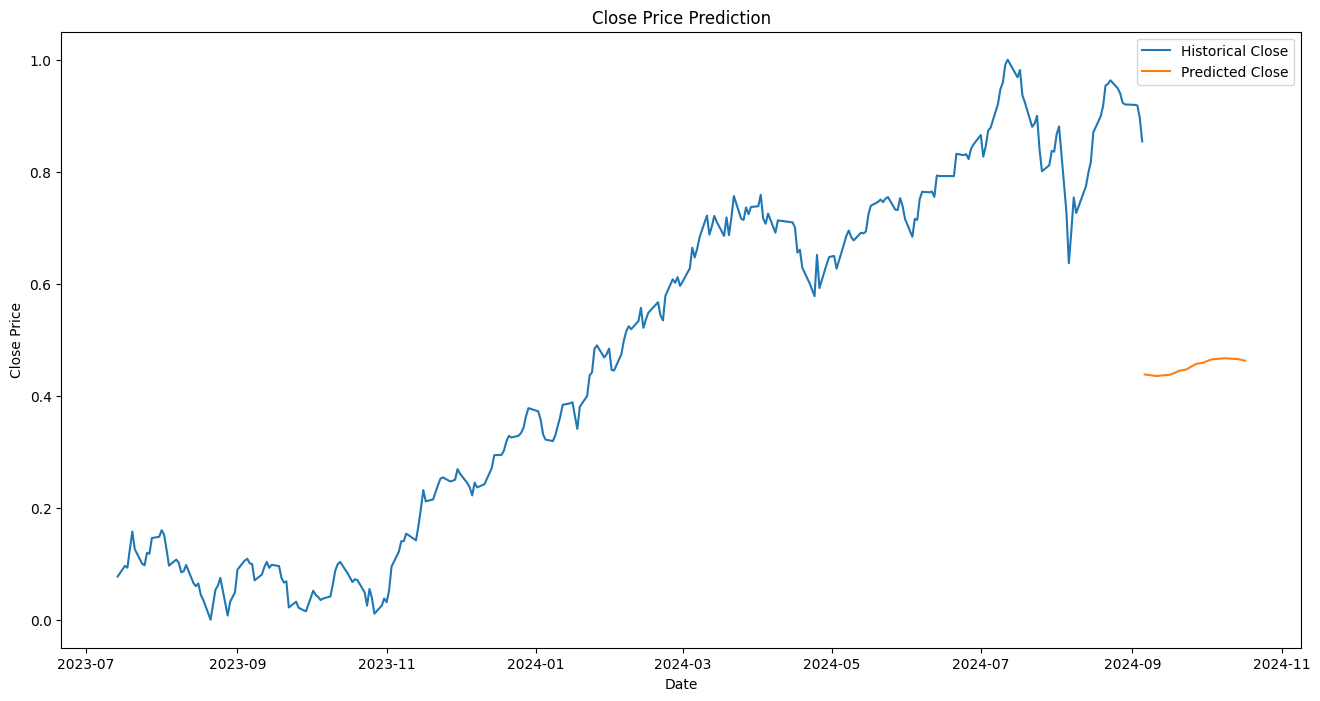

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input

# Load your data
data_import = pd.read_csv('tefas_transformed.csv')
symbols = data_import['symbol'].unique()
symbols = ['AFT']

for symbol in symbols:
    data = data_import[data_import['symbol'] == symbol]

    # Select relevant features (only 'close' in this case)
    data = data[['date', 'close']]

    # Convert 'date' to datetime and set it as index
    data['date'] = pd.to_datetime(data['date'])
    data.set_index('date', inplace=True)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data['close'] = scaler.fit_transform(data['close'].values.reshape(-1, 1))

    # Prepare the data for LSTM
    lookback = 60
    X, Y = [], []

    for i in range(lookback, len(data)):
        X.append(data['close'][i-lookback:i])
        Y.append(data['close'].iloc[i])

    X, Y = np.array(X), np.array(Y)

    # Reshape input to be [samples, time steps, features]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Create and compile the LSTM model
    model = Sequential()
    model.add(Input(shape=(lookback, 1)))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X, Y, epochs=100, batch_size=32)
    # Save the model
    model.save(f'models/{symbol}.keras')

    # Prepare the last 'lookback' days for prediction
    last_sequence = data['close'][-lookback:]

    # Predict the next 30 days
    predictions = []
    current_sequence = last_sequence.values

    for _ in range(30):
        current_sequence = current_sequence.reshape((1, lookback, 1))
        predicted_value = model.predict(current_sequence)
        predictions.append(predicted_value[0, 0])
        current_sequence = np.append(current_sequence[:, 1:, :], predicted_value.reshape(1, 1, 1), axis=1)

    # Inverse transform the predictions
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Create a DataFrame for future predictions
    future_dates = pd.bdate_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30)
    future_df = pd.DataFrame(predictions, index=future_dates, columns=['Predicted Close'])

    # Print or visualize the predictions
    print(future_df)
    # Plot the historical and predicted data
    plt.figure(figsize=(16,8))
    plt.title('Close Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.plot(data['close'], label='Historical Close')
    plt.plot(future_df['Predicted Close'], label='Predicted Close')
    plt.legend()
    plt.show()